In [106]:

#===============================================PHASE 01:Environment Setup===============================================#


In [107]:
print("Installing Required Libraries...\n")

# Import  libraries
import os
import joblib
import warnings
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.exceptions import UndefinedMetricWarning

# Deep learning MLPClassifier llibrary import
from sklearn.neural_network import MLPClassifier 

# Imbalance Data Handling
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Installing imbalanced-learn...")
    os.system('pip install imbalanced-learn')
    from imblearn.over_sampling import SMOTE
    from collections import Counter

# XGBoost ML model library import 
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except ImportError:
    print("Installing xgboost...")
    os.system('pip install xgboost')
    import xgboost as xgb
    from xgboost import XGBClassifier

# file path Configuration
BASE_DIR = os.getcwd()

# Project Folder structure
FOLDER_NAME = '1.CI_CIS6005-II'
PROJECT_PATH = os.path.join(BASE_DIR, FOLDER_NAME)

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'output')
METADATA_PATH = os.path.join(PROJECT_PATH, 'metadata')

# Suppress Warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Create Project  Structure
for path in [PROJECT_PATH, DATA_PATH, MODEL_PATH, OUTPUT_PATH, METADATA_PATH]:
    os.makedirs(path, exist_ok=True)

#plot design librraies
plt.style.use('ggplot')

print(f"Project initialized successfully.")
print(f"\nLibraries Loaded!")
print(f"\nProject Directory Created {PROJECT_PATH}\n")
print("PHASE 01:Library Environment setup finished!\n")

Installing Required Libraries...

Project initialized successfully.

Libraries Loaded!

Project Directory Created C:\Users\hp\1.CI_CIS6005-II

PHASE 01:Library Environment setup finished!



In [108]:

#===============================================PHASE 02:Data Loading===============================================#


In [109]:
print("Starting Data Loading & initial Setup.......\n")

try:
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'car_crash_train.csv'))
    test_df = pd.read_csv(os.path.join(DATA_PATH, 'car_crash_test.csv'))
    sample_submission =  pd.read_csv(os.path.join(DATA_PATH,'sample_submission.csv'))
    
    print("Data Loaded Successfully.")
    print(f"Train Shape: {train_df.shape}")
    print(f"Test Shape: {test_df.shape}")

    print("Sample Submission format:\n")
    print(sample_submission.head())
    print(f"Columns: {list(sample_submission.columns)}")
    
    print("Training data preview:\n")
    print(train_df.head())
    print(f"Columns: {train_df.dtypes}")

except FileNotFoundError:
    print("Data Set File not Found!")

#Target Column definition
TARGET_COL = 'Severity'

print(f"Target Variable identified: {TARGET_COL}\n")
print(f"Target statistics:\n{train_df[TARGET_COL].describe()}\n")

#Chaeck Missing Values train and test data set
train_missing = train_df.isnull().sum().sum()
test_missing = test_df.isnull().sum().sum()

print(f"Training set missing values: {train_missing:,}\n")
print(f"Test set missing values: {test_missing:,}\n")

if TARGET_COL in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[TARGET_COL]):
        target_stats = {
            'mean': float(train_df[TARGET_COL].mean()),
            'median': float(train_df[TARGET_COL].median()),
            'min': float(train_df[TARGET_COL].min()),
            'max': float(train_df[TARGET_COL].max()),
        }
        print(f"Target variable range{target_stats['min']:,.0f} - {target_stats['max']:,.0f}")
    else:
        # For categorical target
        target_stats = {
            'unique_classes': int(train_df[TARGET_COL].nunique()),
            'class_distribution': train_df[TARGET_COL].value_counts().to_dict()
        }
        print(f"Target variable classes {target_stats['unique_classes']}\n")
        print(f"Class distribution {target_stats['class_distribution']}\n")


#save initial metadata
initial_metadata = {
    'dataset_info': {
        'train_Shape': train_df.shape,
        'test_Shape': test_df.shape,
        'target_column': TARGET_COL,
        'total_features': train_df.shape[1] - 1,
    },
    'data_quantity': {
        'train_missig_values': int(train_missing),
        'test_missing_values': int(test_missing),
        'target_stats': target_stats if TARGET_COL in train_df.columns else None   
    },
    'submission_format': {
        'required_columns': list(sample_submission.columns),
        'prediction_type': 'intervals',
        'test_samples': len(sample_submission)
    },
    'feature': {
        'all_columns': train_df.columns.tolist(),
        'numerical_features': train_df.select_dtypes(include=[np.number]).columns.tolist(),
        'categorical_features': train_df.select_dtypes(include=['object']).columns.tolist()
    }
}
metadata_file_path = os.path.join(METADATA_PATH, 'initial_analysis.json')
with open(metadata_file_path, 'w') as f:
     json.dump(metadata_file_path, f, indent=4)

print("Initial meta data saved successfully!\n")
print("PHASE 02: Data set load and intialized finished")

Starting Data Loading & initial Setup.......

Data Loaded Successfully.
Train Shape: (4000, 19)
Test Shape: (1000, 19)
Sample Submission format:

                                     ID Predicted_Severity
0  5ca30a05-b855-4cf3-915f-a92a6be7c010       Minor Injury
1  cc90ec30-fbb8-4f72-8814-8df3b82ea995      Severe Injury
2  a35b1df3-d476-4e21-b4be-54356572decb              Fatal
3  3f6e8e90-e5e7-4f49-93b2-64c1970839ce              Fatal
4  68829fcb-2211-40b4-a9a0-d06a8c6c970c      Severe Injury
Columns: ['ID', 'Predicted_Severity']
Training data preview:

   Crash Speed (km/h)  Impact Angle (degrees) Airbag Deployed Seatbelt Used  \
0                 182                      69             Yes            No   
1                 192                      73             Yes            No   
2                 114                      77              No           Yes   
3                  93                      14              No           Yes   
4                 170                      

In [110]:

#===============================================PHASE 03:Exploratory Data Anlysis===============================================#


Starting EDA section...
Starting Comprehensive EDA Process...

Report Generated at: C:\Users\hp\1.CI_CIS6005-II\output

Missing Data Analysis

Columns with Missing Values:
Distraction Level    59.0
Missing values chart saved to C:\Users\hp\1.CI_CIS6005-II\output\1_missing_values_analysis.png


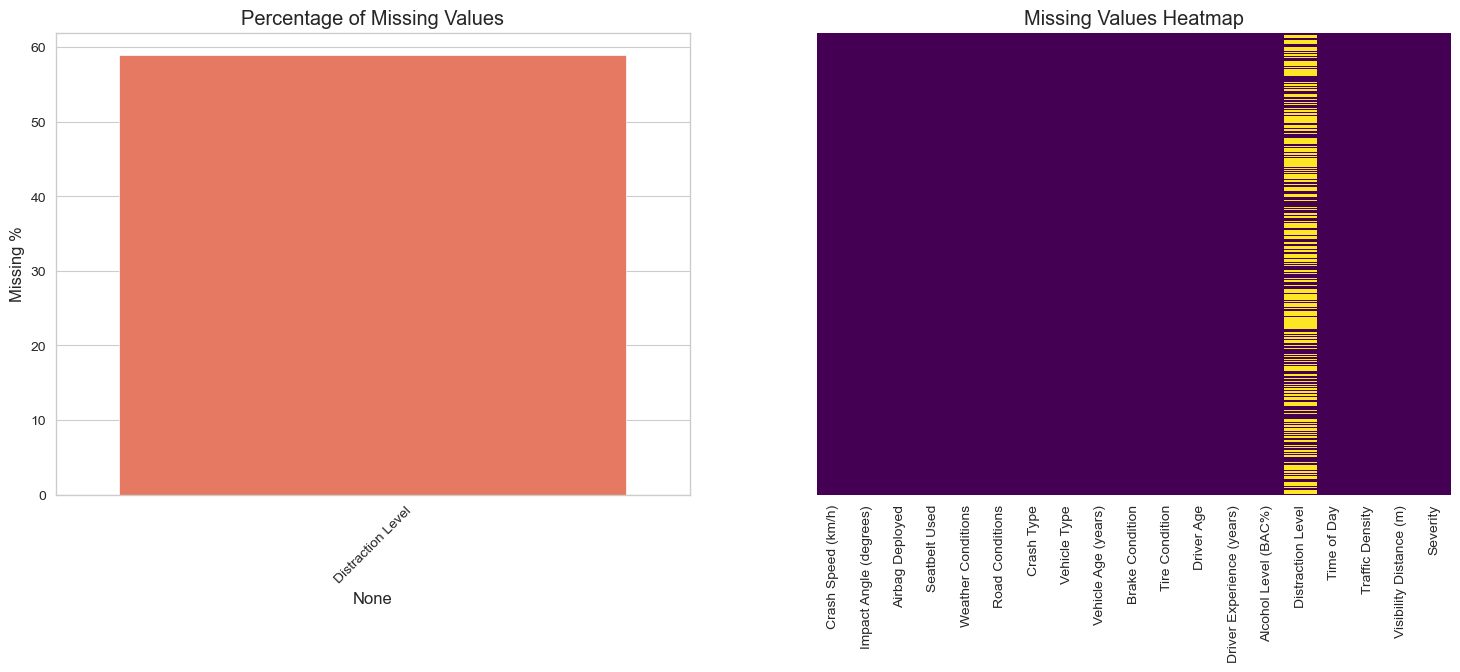


Test Data Missing Analysis

Test Columns with Missing Values:
Distraction Level    60.3
Test missing values chart saved to C:\Users\hp\1.CI_CIS6005-II\output\2_test_missing_values_analysis.png


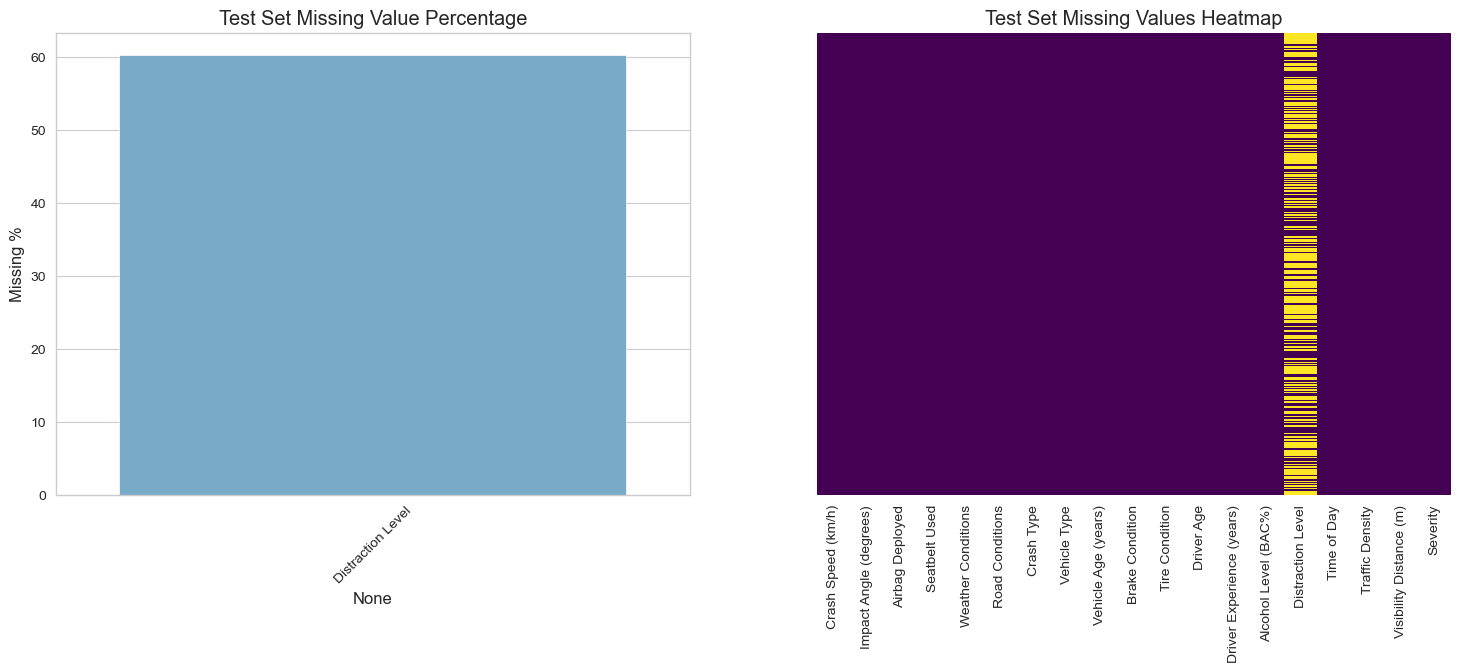


Target Variable Distribution

Target Class Counts:
Severity
Minor Injury     2756
Severe Injury    1038
Fatal             206
Target distribution plot saved to C:\Users\hp\1.CI_CIS6005-II\output\2_target_distribution.png


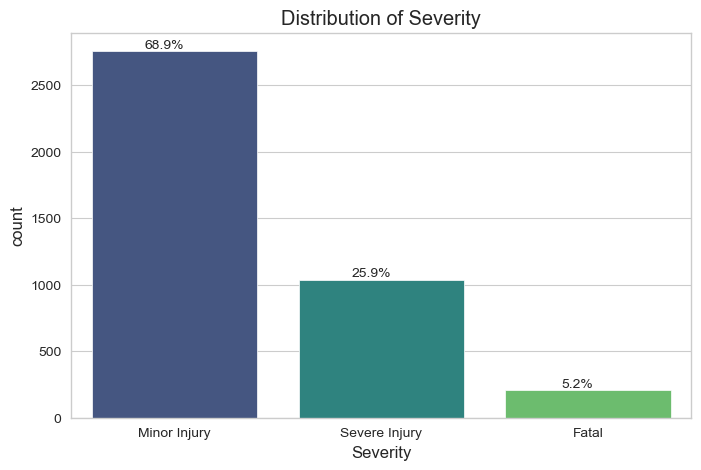


Numerical Features Analysis

Skewness of Numerical Features:
Visibility Distance (m)      0.069922
Vehicle Age (years)          0.028254
Impact Angle (degrees)      -0.010150
Driver Age                  -0.021108
Driver Experience (years)   -0.023710
Alcohol Level (BAC%)        -0.032794
Crash Speed (km/h)          -0.047377

Visualizing Numerical Distributions...
Numerical distribution saved to C:\Users\hp\1.CI_CIS6005-II\output\3_numerical_distribution.png


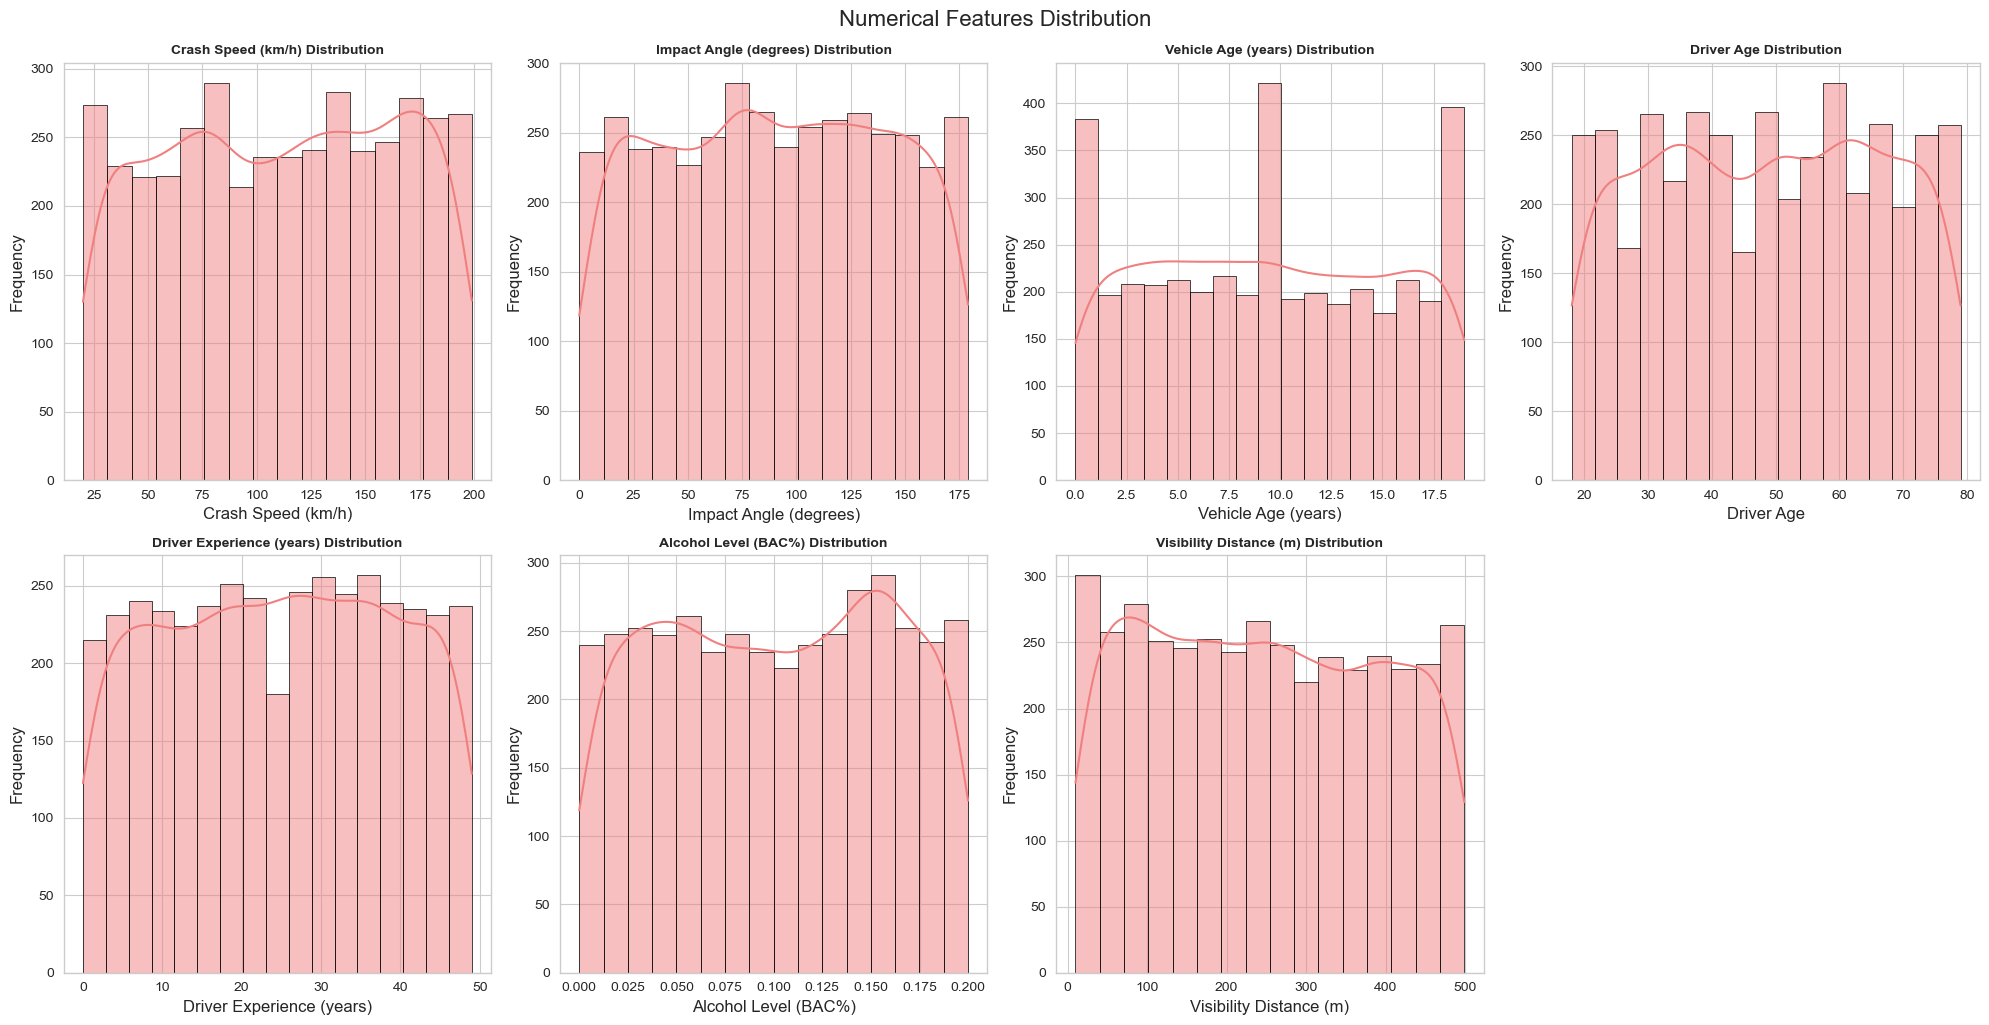


Visualizing Outliers Distribution one by one Numerical Features...
Outlier boxplots saved to C:\Users\hp\1.CI_CIS6005-II\output\4_outlier_boxplots.png


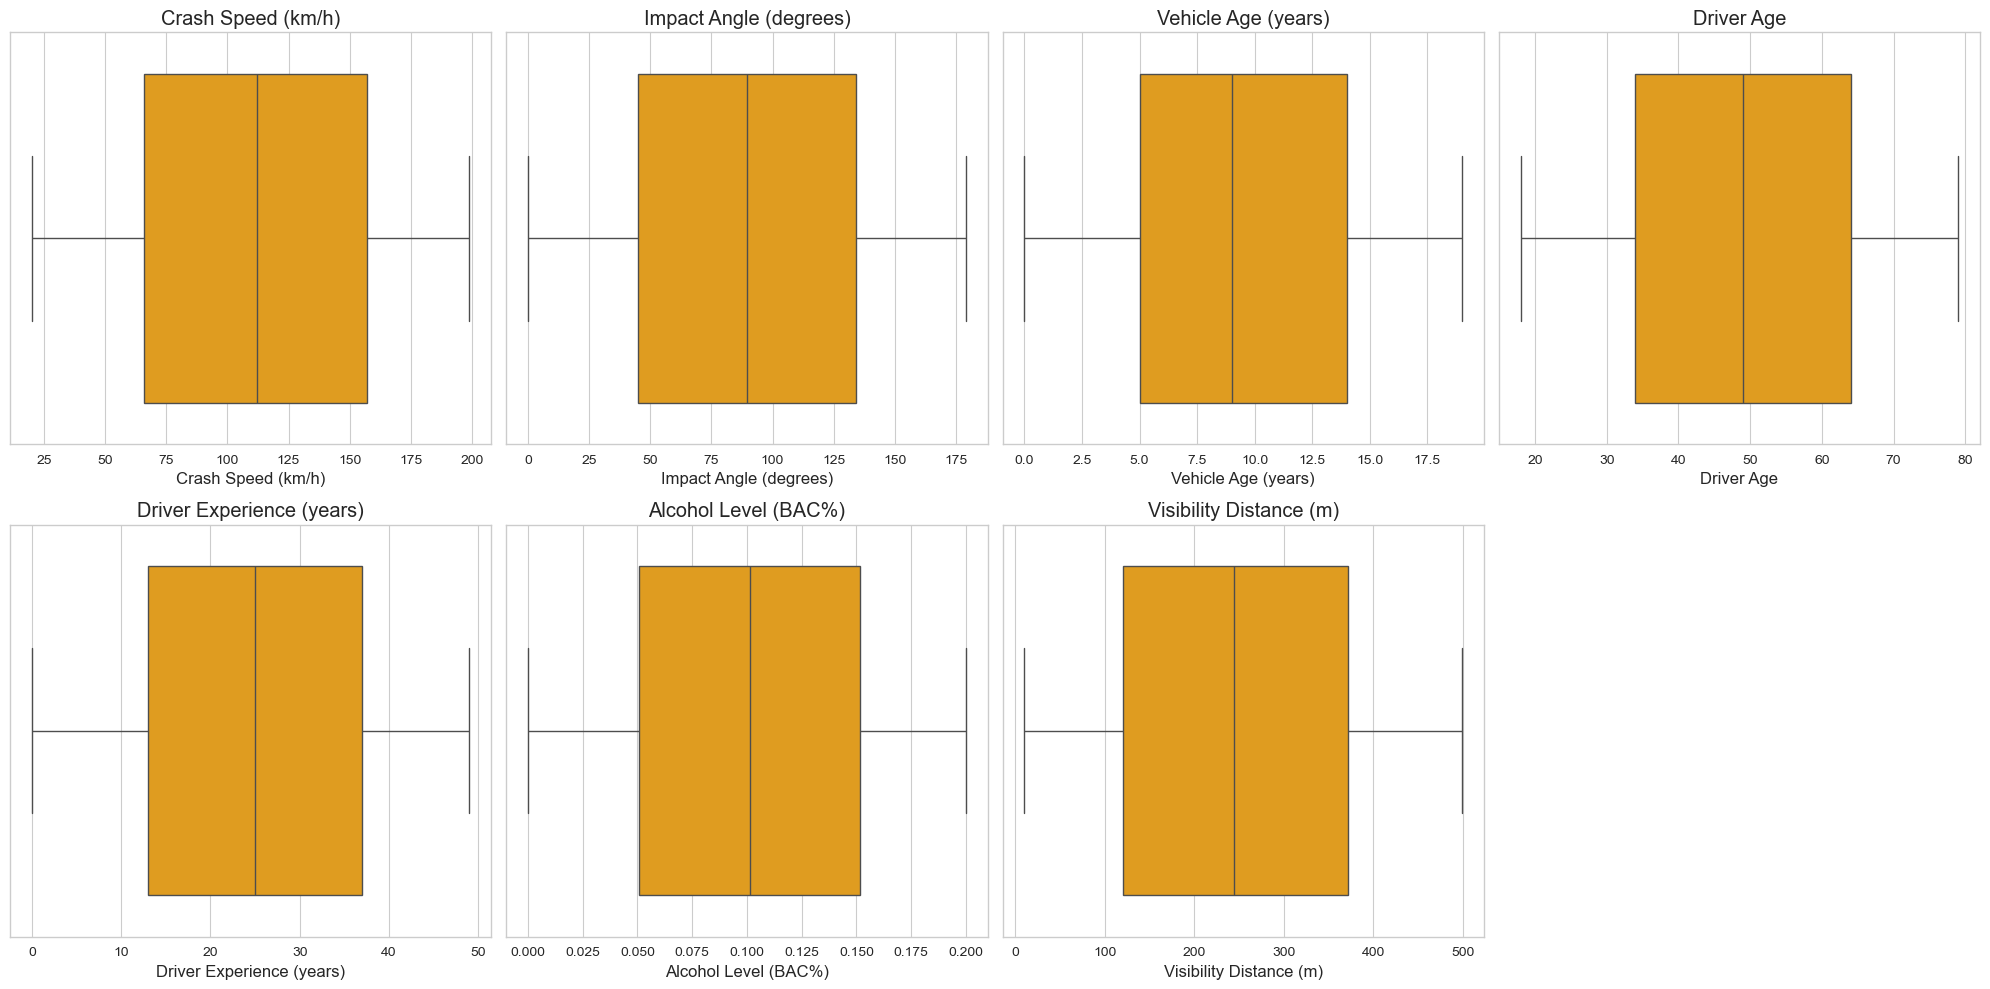


Categorical Features Analysis
Total Categorical Features Here11

Visualizing Categorical Distributions...
Categorical distribution grid saved to C:\Users\hp\1.CI_CIS6005-II\output\5_categorical_distribution.png


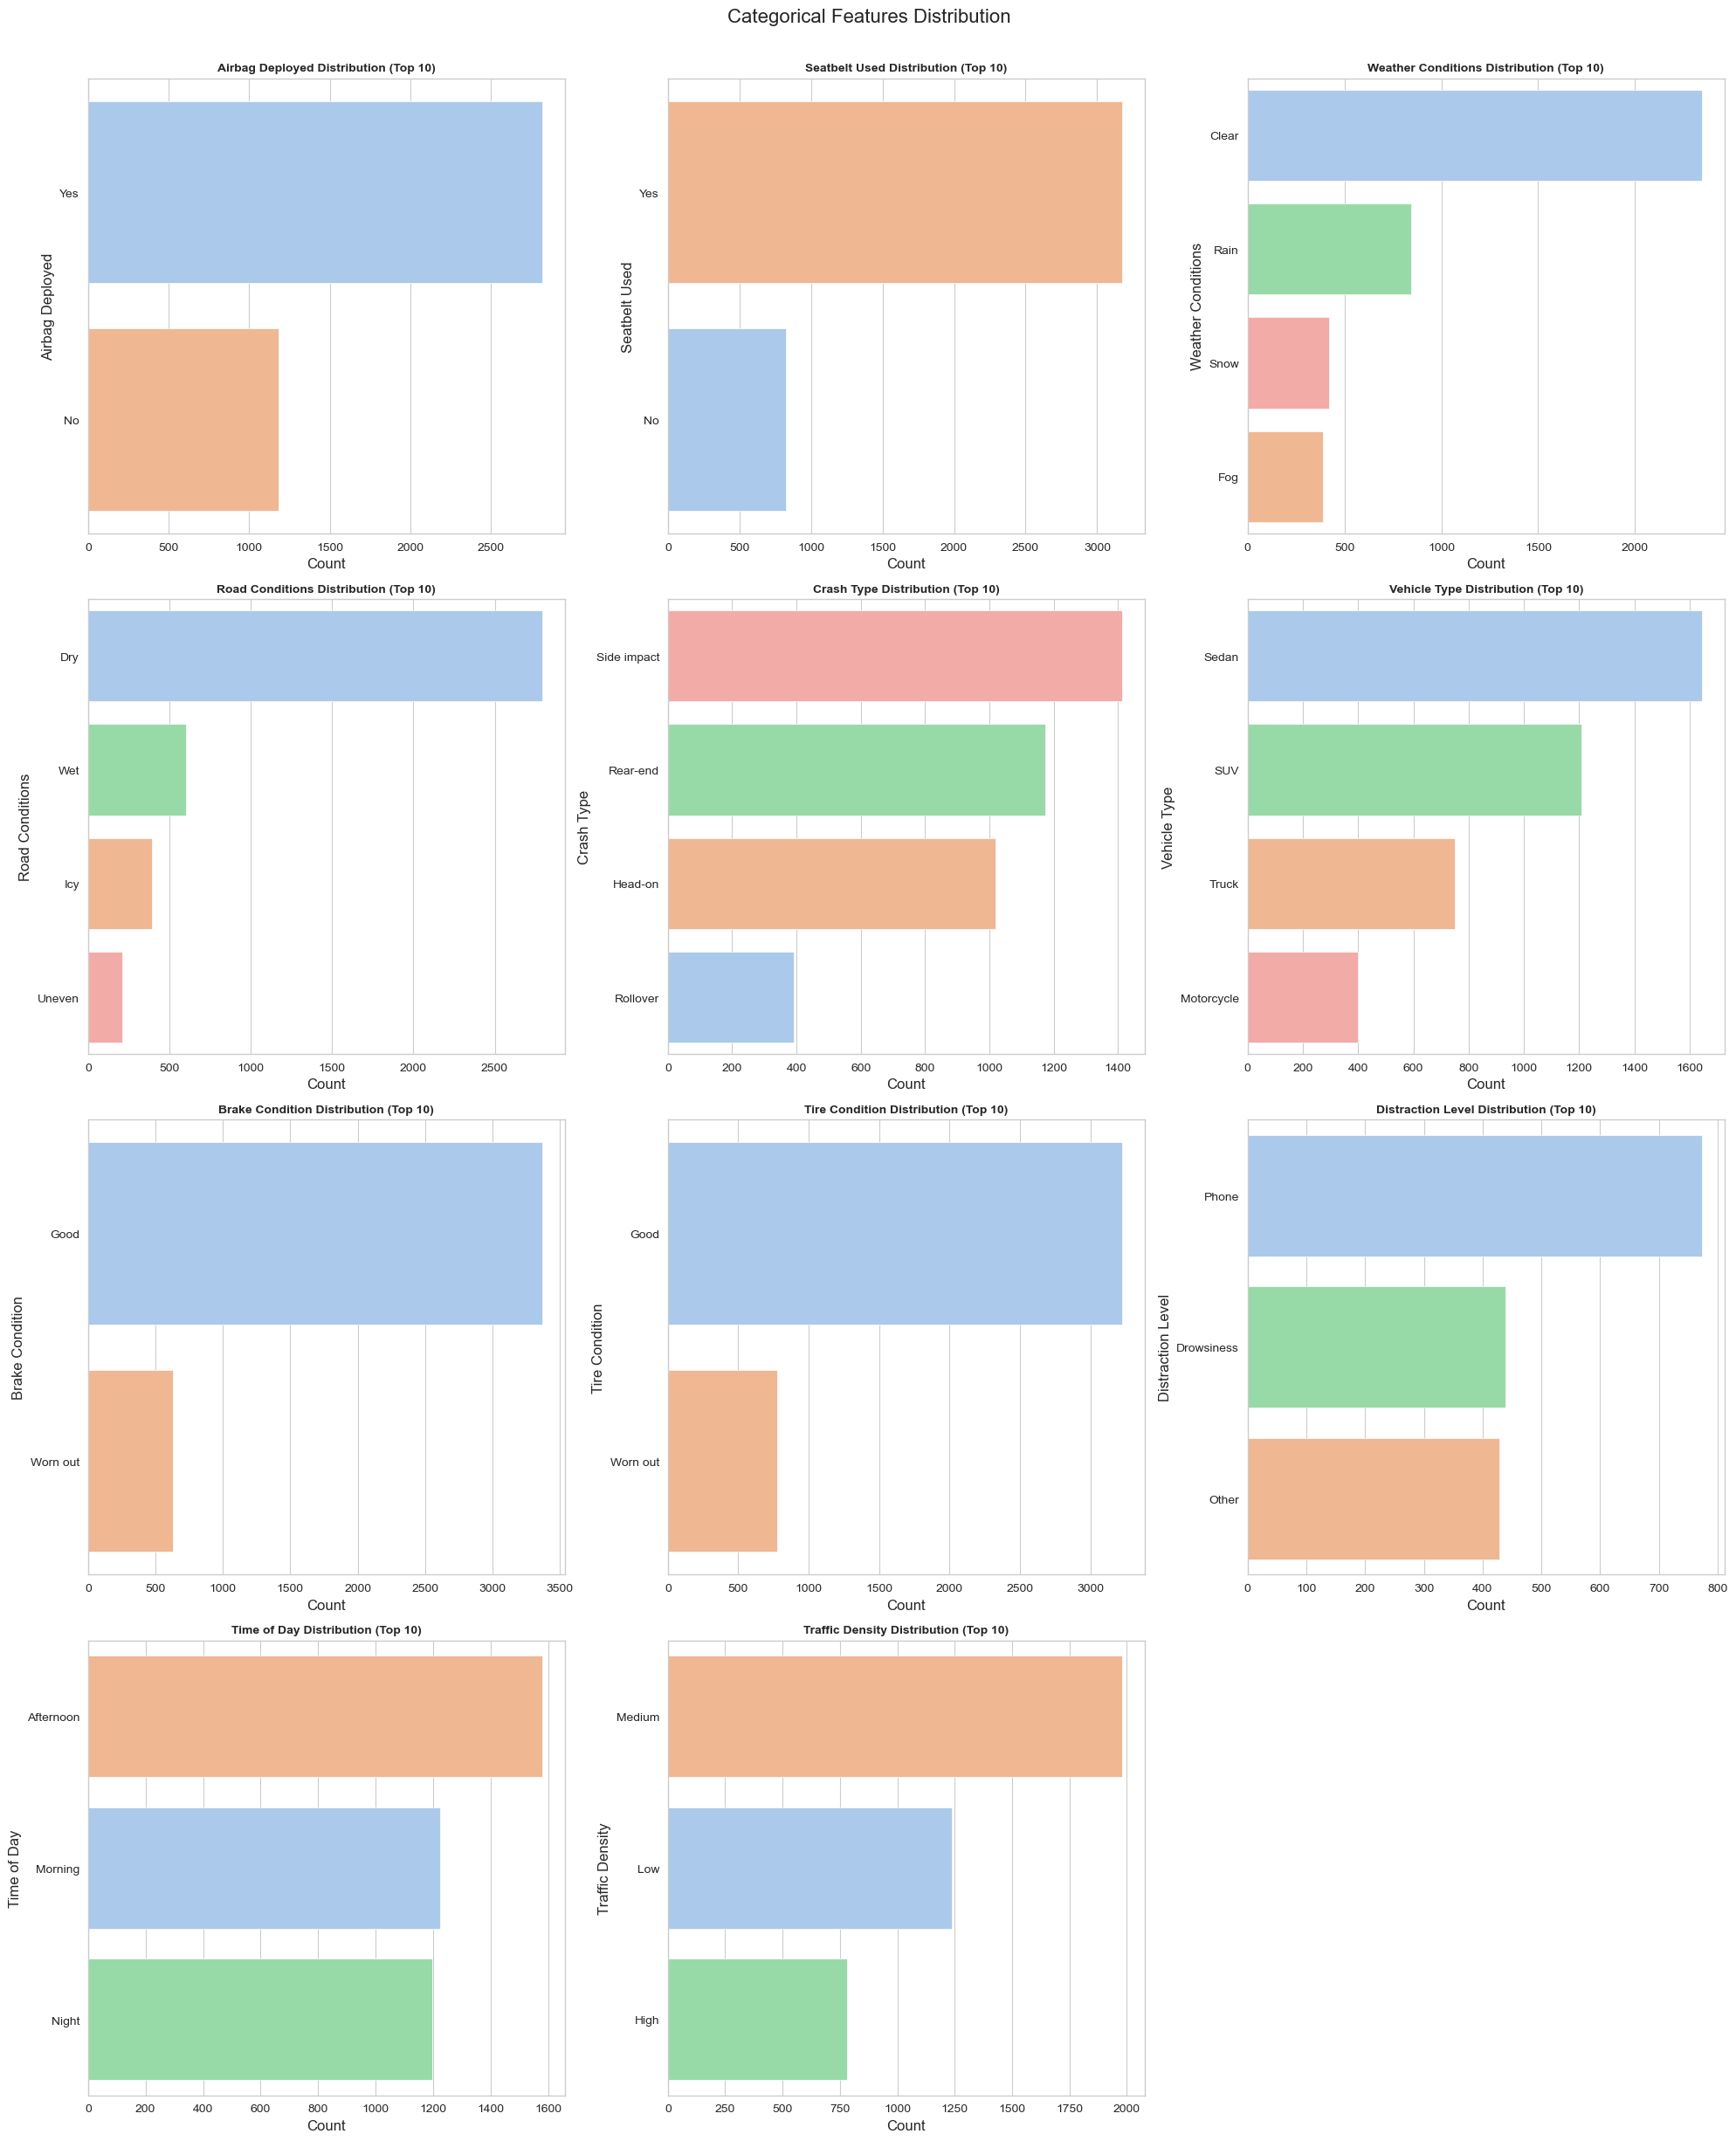


Correlation Matrix
Correlation matrix saved to C:\Users\hp\1.CI_CIS6005-II\output\6_correlation_matrix.png


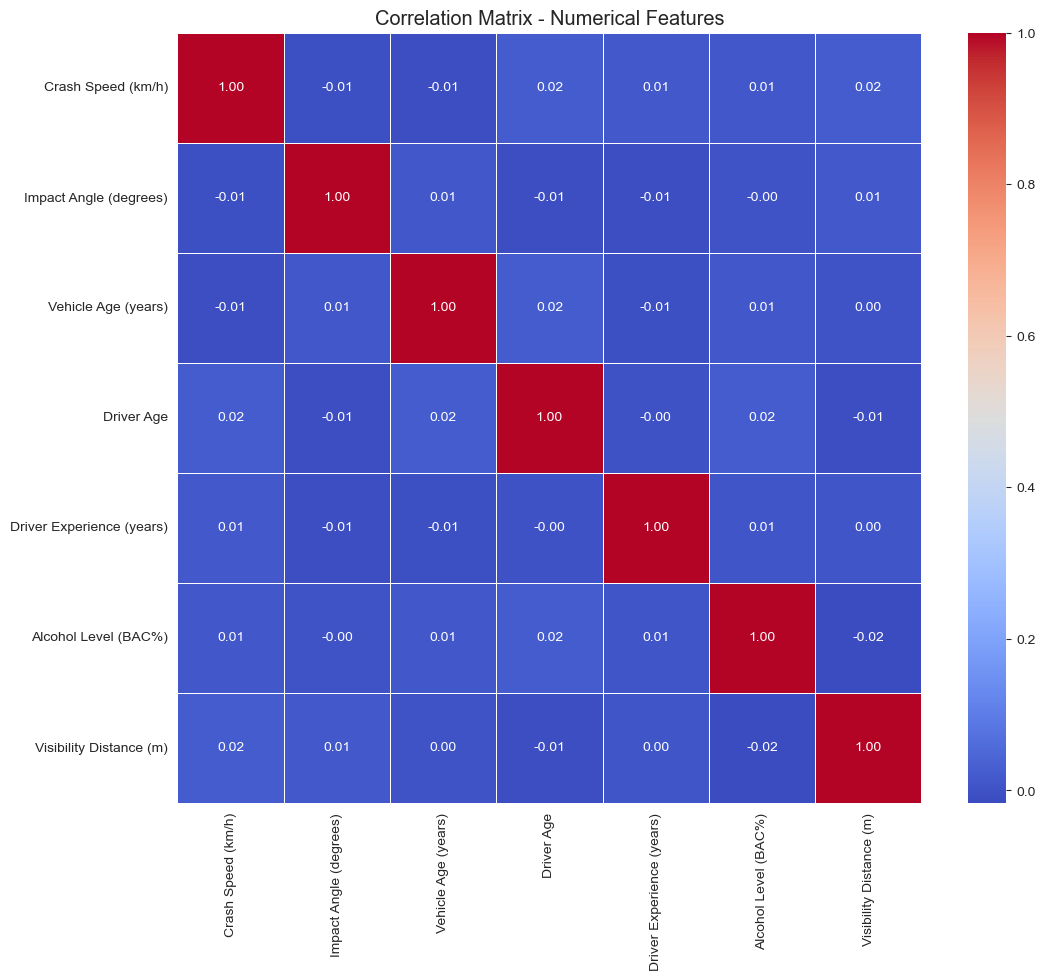


Saving Metadata
Metadata saved successfully to: C:\Users\hp\1.CI_CIS6005-II\metadata\dataset_metadata.json

Full EDA Data saved to: C:\Users\hp\1.CI_CIS6005-II\output\eda_insights_report.txt

PHASE 03 Completed Successfully.


In [111]:
print("Starting EDA section...")
# Set visual style
sns.set_style("whitegrid")

insight_file_path = os.path.join(OUTPUT_PATH, 'eda_insights_report.txt')

def log_insight(text):
    print(text) 
    with open(insight_file_path, 'a') as f: 
        f.write(text + "\n")

if os.path.exists(insight_file_path):
    os.remove(insight_file_path)

log_insight("Starting Comprehensive EDA Process...\n")
log_insight(f"Report Generated at: {OUTPUT_PATH}\n" + "="*50)

#Train Missing Values Analysis
log_insight("\nMissing Data Analysis")
missing_vals = train_df.isnull().sum()
missing_percent = (missing_vals / len(train_df)) * 100
missing_data = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_data.empty:
    log_insight(f"\nColumns with Missing Values:\n{missing_data.to_string()}")
else:
    log_insight("\nmissing values not found ")

# Plotting 
plt.figure(figsize=(18, 6))

# Missing Values Analysis Bar Chart train data set
plt.subplot(1, 2, 1)
if not missing_data.empty:
    sns.barplot(x=missing_data.index, y=missing_data.values, hue=missing_data.index, palette='Reds_r', legend=False)
    plt.title('Percentage of Missing Values')
    plt.ylabel('Missing %')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=15)
    plt.title('Percentage of Missing Values')

# Missing Values Analysis Heatmap train data set
plt.subplot(1, 2, 2)
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')

save_file = os.path.join(OUTPUT_PATH, '1_missing_values_analysis.png')
plt.savefig(save_file)
log_insight(f"Missing values chart saved to {save_file}")
plt.show()

# Test Missing Values Analysis
log_insight("\nTest Data Missing Analysis")

missing_vals_test = test_df.isnull().sum()
missing_percent_test = (missing_vals_test / len(test_df)) * 100
missing_data_test = missing_percent_test[missing_percent_test > 0].sort_values(ascending=False)

if not missing_data_test.empty:
    log_insight(f"\nTest Columns with Missing Values:\n{missing_data_test.to_string()}")
else:
    log_insight("\nTest set missing values not found")

# Plotting
plt.figure(figsize=(18, 6))

# Missing Values Analysis Bar Chart test data set
plt.subplot(1, 2, 1)
if not missing_data_test.empty:
    sns.barplot(
        x=missing_data_test.index,
        y=missing_data_test.values,
        hue=missing_data_test.index,
        palette='Blues_r',
        legend=False
    )
    plt.title('Test Set Missing Value Percentage')
    plt.ylabel('Missing %')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=15)
    plt.title('Test Set Missing Value Percentage')

# Missing Values Analysis Heatmap test data set
plt.subplot(1, 2, 2)
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Test Set Missing Values Heatmap')

save_file_test = os.path.join(OUTPUT_PATH, '2_test_missing_values_analysis.png')
plt.savefig(save_file_test)
log_insight(f"Test missing values chart saved to {save_file_test}")
plt.show()

#Target Variable Distribution plot
log_insight("\nTarget Variable Distribution")
target_counts = train_df[TARGET_COL].value_counts()
log_insight(f"\nTarget Class Counts:\n{target_counts.to_string()}")

plt.figure(figsize=(8, 5))
ax = sns.countplot(x=TARGET_COL, data=train_df, hue=TARGET_COL, palette='viridis', order=target_counts.index, legend=False)

total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title(f'Distribution of {TARGET_COL}')

save_file = os.path.join(OUTPUT_PATH, '2_target_distribution.png')
plt.savefig(save_file)
log_insight(f"Target distribution plot saved to {save_file}")
plt.show()


#Numerical Features Distribution
log_insight("\nNumerical Features Analysis")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

if 'ID' in numeric_cols: numeric_cols.remove('ID')

# Skewness Check for Numerical features
skewness = train_df[numeric_cols].skew().sort_values(ascending=False)
log_insight(f"\nSkewness of Numerical Features:\n{skewness.to_string()}")

print("\nVisualizing Numerical Distributions...")

# Grid Layout
num_features = len(numeric_cols)
n_cols = 4
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i], color='lightcoral', edgecolor='black')
    axes[i].set_title(f'{col} Distribution', fontsize=10, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Numerical Features Distribution', fontsize=16, y=1.02)

save_file = os.path.join(OUTPUT_PATH, '3_numerical_distribution.png')
plt.savefig(save_file)
log_insight(f"Numerical distribution saved to {save_file}")
plt.show()

# Outliers check for numerical features boxplot
print("\nVisualizing Outliers Distribution one by one Numerical Features...")
plt.figure(figsize=(20, 5 * math.ceil(len(numeric_cols)/4)))
for i, col in enumerate(numeric_cols):
    plt.subplot(math.ceil(len(numeric_cols)/4), 4, i+1)
    sns.boxplot(x=train_df[col], color='orange')
    plt.title(f'{col}')
plt.tight_layout()

save_file = os.path.join(OUTPUT_PATH, '4_outlier_boxplots.png')
plt.savefig(save_file)
log_insight(f"Outlier boxplots saved to {save_file}")
plt.show()


#Categorical Features Analysis and Distribution
log_insight("\nCategorical Features Analysis")
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
if TARGET_COL in cat_cols: cat_cols.remove(TARGET_COL)

log_insight(f"Total Categorical Features Here{len(cat_cols)}")

if len(cat_cols) > 0:
    print("\nVisualizing Categorical Distributions...")
    
    num_cat_features = len(cat_cols)
    n_cols_cat = 3 
    n_rows_cat = math.ceil(num_cat_features / n_cols_cat)
    
    fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 6 * n_rows_cat))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        top_categories = train_df[col].value_counts().nlargest(10).index
        sns.countplot(y=col, data=train_df, order=top_categories, ax=axes[i], hue=col, palette='pastel', legend=False)
        
        axes[i].set_title(f'{col} Distribution (Top 10)', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Categorical Features Distribution', fontsize=16, y=1.02)
    save_file = os.path.join(OUTPUT_PATH, '5_categorical_distribution.png')
    plt.savefig(save_file)
    log_insight(f"Categorical distribution grid saved to {save_file}")
    plt.show()
else:
    log_insight("categorical features not found to visualize.")


#Correlation Analysis
log_insight("\nCorrelation Matrix")
plt.figure(figsize=(12, 10))
corr_matrix = train_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features')

save_file = os.path.join(OUTPUT_PATH, '6_correlation_matrix.png')
plt.savefig(save_file)
log_insight(f"Correlation matrix saved to {save_file}")
plt.show()

#Save Metadata as json file in my os path
log_insight("\nSaving Metadata")

meta_data = {
    'numeric_cols': numeric_cols,
    'cat_cols': cat_cols,
    'drop_cols': drop_cols,
    'target_col': TARGET_COL,
    'fill_values': {}
}

for col in train_df.columns:
    if col in numeric_cols:
        meta_data['fill_values'][col] = float(train_df[col].median())
    elif col in cat_cols:
        meta_data['fill_values'][col] = str(train_df[col].mode()[0])

metadata_file_path = os.path.join(METADATA_PATH, 'dataset_metadata.json')

with open(metadata_file_path, 'w') as f:
    json.dump(meta_data, f, indent=4)

log_insight(f"Metadata saved successfully to: {metadata_file_path}")
print(f"\nFull EDA Data saved to: {insight_file_path}")
log_insight("\nPHASE 03 Completed Successfully.")


In [112]:

#===============================================PHASE 04:Preprocessing and Data Cleaning===============================================#


In [113]:
print("Starting Preprocessing and Data Cleaning....\n")

# Load Data from data path
train_df = pd.read_csv(os.path.join(DATA_PATH, 'car_crash_train.csv'))
test_df  = pd.read_csv(os.path.join(DATA_PATH, 'car_crash_test.csv'))

print("Original Train Shape:", train_df.shape)
print("Original Test  Shape:", test_df.shape)

#Missing Value Tretaments
def clean_and_prep_data(df):
    df = df.copy()
    if 'Distraction Level' in df.columns:
        df.drop(columns=['Distraction Level'], inplace=True)
    return df

train_clean = clean_and_prep_data(train_df)
test_clean  = clean_and_prep_data(test_df)

#Outlier detection using IQR Method
print("\nOutlier Detection using IQR Method\n")

numeric_cols = train_clean.select_dtypes(include='number').columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

outliers_dict = {}

for col in numeric_cols:
    Q1 = train_clean[col].quantile(0.25)
    Q3 = train_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_clean[
        (train_clean[col] < lower_bound) |
        (train_clean[col] > upper_bound)
    ]

    outliers_dict[col] = len(outliers)
    print(f"{col} → {len(outliers)} outliers")

# Encode Categorical Features
cat_cols = train_clean.select_dtypes(include='object').columns.tolist()
if TARGET_COL in cat_cols:
    cat_cols.remove(TARGET_COL)

encoders = {}

for col in cat_cols:
    le = LabelEncoder()

    train_clean[col] = le.fit_transform(train_clean[col].astype(str))

    test_clean[col] = test_clean[col].astype(str)
    test_clean[col] = test_clean[col].map(
        lambda x: x if x in le.classes_ else le.classes_[0]
    )
    test_clean[col] = le.transform(test_clean[col])

    encoders[col] = le

# Encode Target variable
le_target = LabelEncoder()
train_clean[TARGET_COL] = le_target.fit_transform(train_clean[TARGET_COL])

print("\nEncoded dtypes:")
print(train_clean.dtypes)

# SMOTE add temparory X,Y 
X_tmp = train_clean.drop(columns=[TARGET_COL])
y_tmp = train_clean[TARGET_COL]

print("\nOriginal Target Distribution:")
print(Counter(y_tmp))

class_counts = Counter(y_tmp)
max_count = max(class_counts.values())
sampling_dict = {cls: max_count for cls in class_counts}

smote = SMOTE(
    random_state=42,
    sampling_strategy=sampling_dict,
    k_neighbors=3
)

X_res, y_res = smote.fit_resample(X_tmp, y_tmp)

print("\nAfter SMOTE:")
print(Counter(y_res))

train_balanced = pd.DataFrame(X_res, columns=X_tmp.columns)
train_balanced[TARGET_COL] = y_res

# Scaling for Neural network
scaler = StandardScaler()
feature_cols = X_tmp.columns
train_balanced[feature_cols] = scaler.fit_transform(
    train_balanced[feature_cols]
)

test_features = test_clean.drop(columns=['ID', TARGET_COL], errors='ignore')
test_clean[test_features.columns] = scaler.transform(test_features)

print("\nScaled training sample:")
print(train_balanced.head())

# SAVE Train ready data set
train_balanced.to_csv(
    os.path.join(DATA_PATH, 'train_processed.csv'),
    index=False
)

# CREATE test_processed_extended.csv for generate submission file
test_processed = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)
test_1000 = test_processed.iloc[:1000]

extra_rows_needed = 5000 - len(test_1000)
extra_4000 = test_processed.sample(
    n=extra_rows_needed,
    replace=True,
    random_state=42
)

combined_test = pd.concat(
    [test_1000, extra_4000],
    ignore_index=True
)

combined_test['ID'] = range(1, len(combined_test) + 1)

combined_test.to_csv(
    os.path.join(DATA_PATH, 'test_processed_extended.csv'),
    index=False
)

print("\nSaved Files:")
print("train_processed.csv with balanced SMOTE")
print("test_processed_extended.csv")

# Save Artifcats
joblib.dump(
    {
        'scaler': scaler,
        'encoders': encoders,
        'target_encoder': le_target,
        'features': feature_cols.tolist()
    },
    os.path.join(MODEL_PATH, 'preprocessing_artifacts.pkl')
)

print("\nPHASE 04: Preprocessing Completed Successfully!")


Starting Preprocessing and Data Cleaning....

Original Train Shape: (4000, 19)
Original Test  Shape: (1000, 19)

Outlier Detection using IQR Method

Crash Speed (km/h) → 0 outliers
Impact Angle (degrees) → 0 outliers
Vehicle Age (years) → 0 outliers
Driver Age → 0 outliers
Driver Experience (years) → 0 outliers
Alcohol Level (BAC%) → 0 outliers
Visibility Distance (m) → 0 outliers

Encoded dtypes:
Crash Speed (km/h)             int64
Impact Angle (degrees)         int64
Airbag Deployed                int64
Seatbelt Used                  int64
Weather Conditions             int64
Road Conditions                int64
Crash Type                     int64
Vehicle Type                   int64
Vehicle Age (years)            int64
Brake Condition                int64
Tire Condition                 int64
Driver Age                     int64
Driver Experience (years)      int64
Alcohol Level (BAC%)         float64
Time of Day                    int64
Traffic Density                int64
Visibil

In [114]:

#===============================================PHASE 05:Individual Model Training===============================================#


In [115]:
print("Starting Model Training Process.....\n")

# Load Proccessd Data Set
train_processed = pd.read_csv(os.path.join(DATA_PATH, 'train_processed.csv'))

#Load preprocessing saved pkl file
artifacts = joblib.load(os.path.join(MODEL_PATH, 'preprocessing_artifacts.pkl'))
le_target = artifacts['target_encoder']

# Split features & target definition
X = train_processed.drop(columns=[TARGET_COL])
y = train_processed[TARGET_COL]

print("Train processed shape:", X.shape)

#Train Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training shape :", X_train.shape)
print("Validation shape:", X_val.shape)

#Models Training one by one separately
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ),
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=42
    ),
   "XGBClassifier" : XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)
}

trained_models = {}
results = []

#Train Model Validation check
for name, model in models.items():
    print(f"\n{'='*55}")
    print(f"Training {name}")
    print(f"{'='*55}")

    model.fit(X_train, y_train)
    trained_models[name] = model

    # Predict
    y_pred = model.predict(X_val)

    # Decode labels for readable report
    y_val_lbl  = le_target.inverse_transform(y_val)
    y_pred_lbl = le_target.inverse_transform(y_pred)

    print(f"\nClassification Report ({name}):")
    print(classification_report(y_val_lbl, y_pred_lbl, zero_division=0))

    results.append({
        "Model": name,
        "F1 Score": f1_score(y_val_lbl, y_pred_lbl, average="weighted"),
        "Recall": recall_score(y_val_lbl, y_pred_lbl, average="weighted"),
        "Precision": precision_score(y_val_lbl, y_pred_lbl, average="weighted"),
        "Accuracy": accuracy_score(y_val_lbl, y_pred_lbl)
    })

#Confusion Metrix
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

print("\n=== VALIDATION METRICS SUMMARY ===")
print(results_df)

#Save Models details separately with model data
for name, model in trained_models.items():
    model_path = os.path.join(
        MODEL_PATH,
        f"{name.replace(' ', '_').lower()}.pkl"
    )
    joblib.dump(model, model_path)

print("\nPHASE 05: Separately Model Training Successfully!")


Starting Model Training Process.....

Train processed shape: (8268, 17)
Training shape : (6614, 17)
Validation shape: (1654, 17)

Training Random Forest

Classification Report (Random Forest):
               precision    recall  f1-score   support

        Fatal       0.63      0.89      0.74       551
 Minor Injury       0.63      0.75      0.68       551
Severe Injury       0.71      0.29      0.41       552

     accuracy                           0.64      1654
    macro avg       0.66      0.64      0.61      1654
 weighted avg       0.66      0.64      0.61      1654


Training MLP Classifier

Classification Report (MLP Classifier):
               precision    recall  f1-score   support

        Fatal       0.84      0.91      0.88       551
 Minor Injury       0.64      0.70      0.67       551
Severe Injury       0.71      0.58      0.64       552

     accuracy                           0.73      1654
    macro avg       0.73      0.73      0.73      1654
 weighted avg       0

In [116]:

#===============================================PHASE 06:Best Model Evaluation and submission===============================================#


Starting Best Model Evaluation...

Sample submission preview:
                                     ID Predicted_Severity
0  5ca30a05-b855-4cf3-915f-a92a6be7c010       Minor Injury
1  cc90ec30-fbb8-4f72-8814-8df3b82ea995      Severe Injury
2  a35b1df3-d476-4e21-b4be-54356572decb              Fatal
3  3f6e8e90-e5e7-4f49-93b2-64c1970839ce              Fatal
4  68829fcb-2211-40b4-a9a0-d06a8c6c970c      Severe Injury

********Model Performance Summary********
         Model  F1 Score  Accuracy  Precision   Recall
 XGBClassifier  0.799489  0.801088   0.798509 0.801088
MLP Classifier  0.726408  0.730351   0.728284 0.730351
 Random Forest  0.610691  0.642080   0.658716 0.642080

BEST MODEL: XGBClassifier
Best Model confusion Metrix C:\Users\hp\1.CI_CIS6005-II\output\7_Confusion_Matrix_XGBoost.png


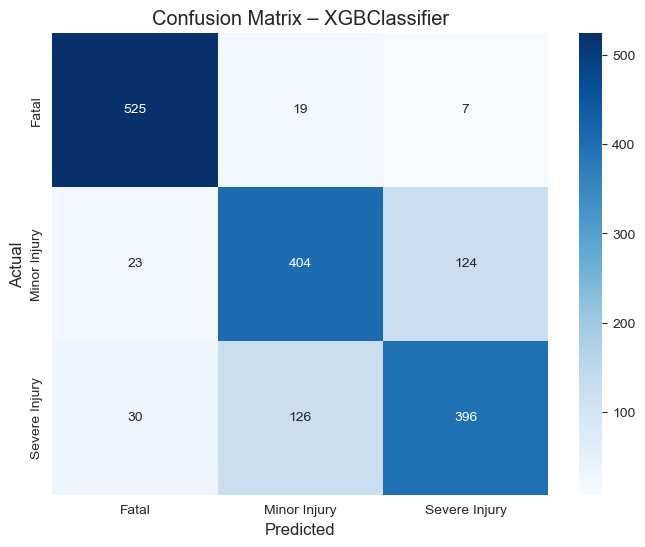


Final Keggale submission file created!
Saved at: C:\Users\hp\1.CI_CIS6005-II\output\final_submission.csv
                                     ID Predicted_Severity
0  5ca30a05-b855-4cf3-915f-a92a6be7c010       Minor Injury
1  cc90ec30-fbb8-4f72-8814-8df3b82ea995       Minor Injury
2  a35b1df3-d476-4e21-b4be-54356572decb       Minor Injury
3  3f6e8e90-e5e7-4f49-93b2-64c1970839ce       Minor Injury
4  68829fcb-2211-40b4-a9a0-d06a8c6c970c       Minor Injury


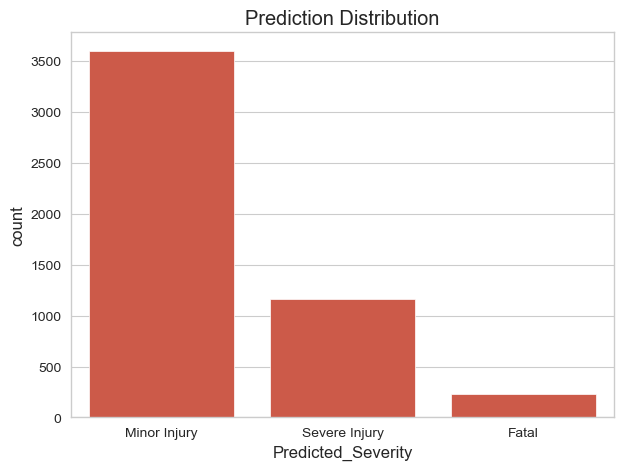

Prediction Distribution on Test Set:
                    Count  Percentage (%)
Predicted_Severity                       
Fatal                 233            4.66
Minor Injury         3600           72.00
Severe Injury        1167           23.34

Top 1 Important Features:
                    Feature  Importance
10           Tire Condition    0.099283
9           Brake Condition    0.084360
6                Crash Type    0.080311
5           Road Conditions    0.076051
2           Airbag Deployed    0.067678
3             Seatbelt Used    0.067568
15          Traffic Density    0.064724
14              Time of Day    0.059976
4        Weather Conditions    0.056904
7              Vehicle Type    0.051672
16  Visibility Distance (m)    0.046425
11               Driver Age    0.043098
0        Crash Speed (km/h)    0.041019
8       Vehicle Age (years)    0.040988
1    Impact Angle (degrees)    0.040735
Top 15 Feature Importance saved to C:\Users\hp\1.CI_CIS6005-II\output\8_Feature_Import

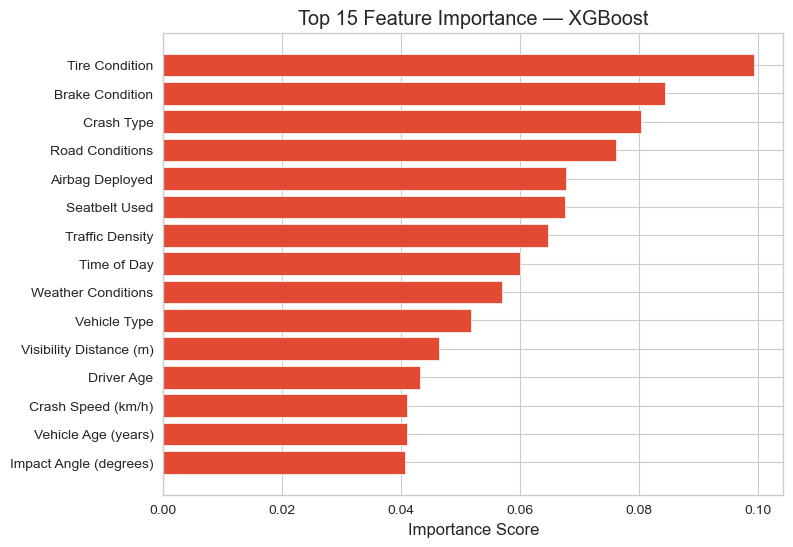


System artifact saved

PHASE 06 : Model Comaprison and evaluation Successfully!


In [117]:
print("Starting Best Model Evaluation...\n")

#Load Sample dataset
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

print("Sample submission preview:")
print(sample_submission.head())

ID_COL = sample_submission.columns[0]
TARGET_SUB_COL = sample_submission.columns[1]

#Load Preprocessing pkl file
artifacts = joblib.load(os.path.join(MODEL_PATH, 'preprocessing_artifacts.pkl'))
le_target   = artifacts['target_encoder']
feature_cols = artifacts['features']

#Load Results
results_df = pd.DataFrame(results)
results_df['F1 Score (%)'] = results_df['F1 Score'] * 100

print("\n********Model Performance Summary********")
print(
    results_df[['Model', 
                'F1 Score',
                'Accuracy', 
                'Precision', 
                'Recall']]
    .sort_values(by='F1 Score', ascending=False)
    .to_string(index=False, formatters={'F1 Score (%)': '{:.2f}%'.format})
)

#Best Model Selection
best_row = results_df.loc[results_df['F1 Score'].idxmax()]
best_model_name = best_row['Model']
best_model = trained_models[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")

#Best Model confusion Metrix
y_val_true_lbl = le_target.inverse_transform(y_val)
y_val_pred_lbl = le_target.inverse_transform(best_model.predict(X_val))

cm = confusion_matrix(y_val_true_lbl, y_val_pred_lbl)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
save_file = os.path.join(OUTPUT_PATH, '7_Confusion_Matrix_XGBoost.png')
plt.savefig(save_file)
print(f"Best Model confusion Metrix {save_file}")
plt.show()

#Load Test data set
test_ext = pd.read_csv(os.path.join(DATA_PATH, 'test_processed_extended.csv'))

X_test = test_ext[feature_cols]

#Prediction Process
test_pred_enc = best_model.predict(X_test)
test_pred_lbl = le_target.inverse_transform(test_pred_enc)

#Create Final summery
final_submission = sample_submission.copy()

final_submission[TARGET_SUB_COL] = test_pred_lbl[:len(sample_submission)]

# HARD VALIDATION
assert list(final_submission.columns) == list(sample_submission.columns), \
    "Column mismatch with sample submission"

assert final_submission[ID_COL].equals(sample_submission[ID_COL]), \
    "ID column modified"

submission_path = os.path.join(OUTPUT_PATH, 'final_submission.csv')
final_submission.to_csv(submission_path, index=False)

print("\nFinal Keggale submission file created!")
print("Saved at:", submission_path)
print(final_submission.head())

#How to distribute predictions
plt.figure(figsize=(7, 5))
sns.countplot(x=TARGET_SUB_COL, data=final_submission)
plt.title("Prediction Distribution")
plt.show()

# Count of each predicted class
pred_counts = final_submission[TARGET_SUB_COL].value_counts()

# Percentage of each class
pred_percent = final_submission[TARGET_SUB_COL].value_counts(normalize=True) * 100

# Combine into a single table
prediction_stats = pd.DataFrame({
    'Count': pred_counts,
    'Percentage (%)': pred_percent
}).sort_index() 

print("Prediction Distribution on Test Set:")
print(prediction_stats)

#Feature Importance
train_processed = pd.read_csv(os.path.join(DATA_PATH, 'train_processed.csv'))

X = train_processed.drop(columns=[TARGET_COL])
y = train_processed[TARGET_COL]

# Load trained best model
xgb_model = joblib.load(os.path.join(MODEL_PATH, 'xgbclassifier.pkl'))

# Get feature importance
importances = xgb_model.feature_importances_

feat_imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 1 Important Features:")
print(feat_imp_df.head(15))

# Plot
plt.figure(figsize=(8,6))
plt.barh(
    feat_imp_df.head(15)["Feature"],
    feat_imp_df.head(15)["Importance"]
)
plt.gca().invert_yaxis()
save_file = os.path.join(OUTPUT_PATH, '8_Feature_Importance_XGBoost.png')
plt.title("Top 15 Feature Importance — XGBoost")
plt.savefig(save_file)
print(f"Top 15 Feature Importance saved to {save_file}")
plt.xlabel("Importance Score")
plt.show()


#Save Best model full System data as pkl file
final_system = {
    'model': best_model,
    'target_encoder': le_target,
    'features': feature_cols
}

joblib.dump(
    final_system,
    os.path.join(MODEL_PATH, 'crash_severity_system.pkl')
)

print("\nSystem artifact saved")
print("\nPHASE 06 : Model Comaprison and evaluation Successfully!")


In [118]:

#===============================================PHASE 07:Check prediction using Original Test data===============================================#


In [119]:
#Configuration models
PROJECT_PATH = "."
MODEL_PATH = os.path.join(PROJECT_PATH, "models")

#Load Best Model full data pkl file
system = joblib.load(os.path.join(MODEL_PATH, "crash_severity_system.pkl"))

best_model   = system["model"]          
le_target    = system["target_encoder"]
feature_cols = system["features"]

#Load Preprocessd phase all data pkl file
artifacts = joblib.load(os.path.join(MODEL_PATH, "preprocessing_artifacts.pkl"))
scaler   = artifacts["scaler"]
encoders = artifacts["encoders"]

print("Model & artifacts loaded correctly")

#Preprocessd as singal line
def preprocess_single_input(input_dict):

    df = pd.DataFrame([input_dict])

    #encode categoricals safely
    for col, le in encoders.items():
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            df[col] = le.transform(df[col])

    #ensure all training features exist
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0

    df = df[feature_cols]

    #scale
    X_scaled = scaler.transform(df)
    return X_scaled

#Predcitions Funcrtion
def predict_crash_severity(input_dict):

    X_scaled = preprocess_single_input(input_dict)

    pred_encoded = best_model.predict(X_scaled)
    pred_label = le_target.inverse_transform(pred_encoded)[0]

    conf = None
    if hasattr(best_model, "predict_proba"):
        conf = float(np.max(best_model.predict_proba(X_scaled)))
    return pred_label, conf

#Sample test input data
sample_inputs = [
   {
    "Crash Speed (km/h)": 194,              
    "Impact Angle (degrees)": 154,          
    "Airbag Deployed": "Yes",                
    "Seatbelt Used": "No",                  
    "Weather Conditions": "Rain",          
    "Road Conditions": "Dry",                
    "Crash Type": "Rollover",                
    "Vehicle Type": "SUV",            
    "Vehicle Age (years)": 2,               
    "Brake Condition": "Wron out",               
    "Tire Condition": "Good",                
    "Driver Age": 37,                        
    "Driver Experience (years)": 24,         
    "Alcohol Level (BAC%)": 0.07,             
    "Time of Day": "Afternoon",                 
    "Traffic Density": "Median",               
    "Visibility Distance (m)": 23            
}, {
    "Crash Speed (km/h)": 35,
    "Impact Angle (degrees)": 15,
    "Airbag Deployed": "No",
    "Seatbelt Used": "Yes",
    "Weather Conditions": "Clear",
    "Road Conditions": "Dry",
    "Crash Type": "Rear-end",
    "Vehicle Type": "Hatchback",
    "Vehicle Age (years)": 3,
    "Brake Condition": "Good",
    "Tire Condition": "Good",
    "Driver Age": 28,
    "Driver Experience (years)": 5,
    "Alcohol Level (BAC%)": 0.0,
    "Time of Day": "Day",
    "Traffic Density": "Low",
    "Visibility Distance (m)": 300
},{
    "Crash Speed (km/h)": 162,             
    "Impact Angle (degrees)": 85,
    "Airbag Deployed": "Yes",                
    "Seatbelt Used": "Yes",                  
    "Weather Conditions": "Clear",           
    "Road Conditions": "Icy",               
    "Crash Type": "Rear-end",                
    "Vehicle Type": "SUV",           
    "Vehicle Age (years)": 17,              
    "Brake Condition": "Good",               
    "Tire Condition": "Worn out",               
    "Driver Age": 38,                       
    "Driver Experience (years)": 7,         
    "Alcohol Level (BAC%)": 0.09,            
    "Time of Day": "Night",                 
    "Traffic Density": "Mediun",               
    "Visibility Distance (m)": 256           
},{
    "Crash Speed (km/h)": 182,              
    "Impact Angle (degrees)": 57,           
    "Airbag Deployed": "Yes",                
    "Seatbelt Used": "Yes",                  
    "Weather Conditions": "Clear",          
    "Road Conditions": "Dry",               
    "Crash Type": "Side impact",                 
    "Vehicle Type": "Sedan",            
    "Vehicle Age (years)": 9,               
    "Brake Condition": "Good",               
    "Tire Condition": "Good",                
    "Driver Age": 61,                        
    "Driver Experience (years)": 5,         
    "Alcohol Level (BAC%)": 0.12,            
    "Time of Day": "Night",                  
    "Traffic Density": "Mediun",               
    "Visibility Distance (m)": 220           
}
]

#Check predictions with confidence
rows = []

for i, inp in enumerate(sample_inputs, start=1):
    pred, conf = predict_crash_severity(inp)
    rows.append({
        "Sample_ID": i,
        "Predicted_Severity": pred,
        "Confidence": round(conf, 3) if conf is not None else None
    })

final_demo_df = pd.DataFrame(rows)

print("\n====Predictions====")
print(final_demo_df)


Model & artifacts loaded correctly

====Predictions====
   Sample_ID Predicted_Severity  Confidence
0          1              Fatal       0.713
1          2       Minor Injury       0.607
2          3      Severe Injury       0.483
3          4              Fatal       0.767
